# Assignment 2 - Stitching

_Tiffany Wang - 260684152_ 

In [1]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
from PIL import Image

#### 1. Compute SIFT keypoints and corresponding descriptors for images 1Hill and 2Hill.


In [27]:
hill1 = Image.open('./stitching_images/1Hill.JPG')
hill2 = Image.open('./stitching_images/2Hill.JPG')
hill3 = Image.open('./stitching_images/3Hill.JPG')

In [32]:
###############################################################
# Find SIFT keypoints and corresponding descriptors for 1Hill #
###############################################################

# copy of image 
hill1_c = hill1.copy()
hill1 = np.array(hill1)

# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# detect SIFT features, with no masks
kp1, des1 = sift.detectAndCompute(hill1, None)

# draw the keypoints
cv2.drawKeypoints(hill1, kp1, hill1_c, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# display
plt.figure(figsize=(15,7))
plt.subplot(121), plt.imshow(hill1)
plt.title("Hill1 - Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hill1_c)
plt.title("Hill1 - SIFT Features"), plt.xticks([]), plt.yticks([])
plt.show()

# num of SIFT descriptors
print('descriptors size: '+ str(des2.shape))

# plot a couple of 1x128 SIFT descriptors
num = 10
plt.figure(figsize=(15, 5))
plt.title('Hill1 - Descriptors')
for i in range(num):
    plt.plot(des1[i])
    plt.xlim([0,128]) 
plt.show()

TypeError: outImage is not a numpy array, neither a scalar

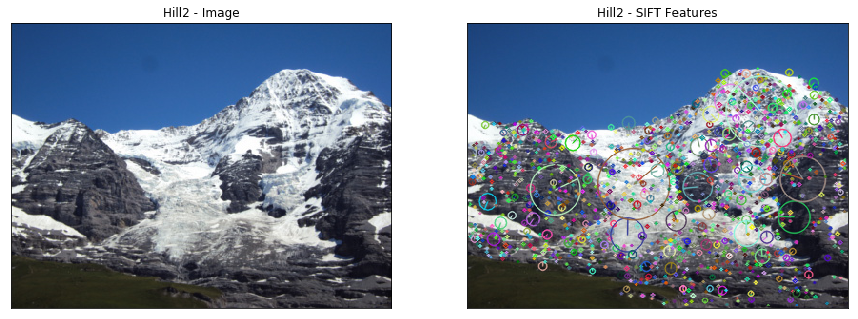

descriptors size: (1472, 128)


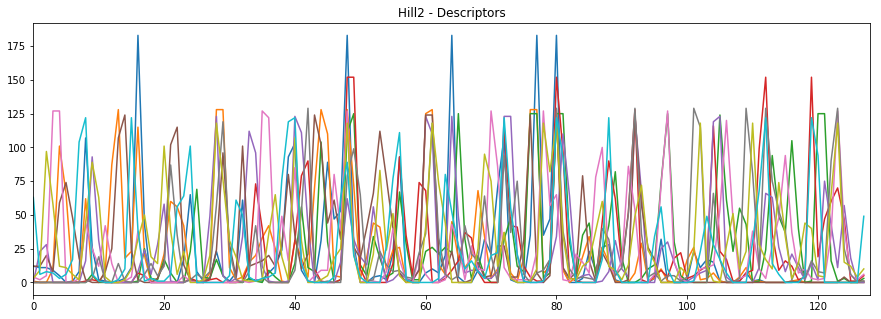

In [33]:
###############################################################
# Find SIFT keypoints and corresponding descriptors for 2Hill #
###############################################################

# copy of image 
hill2 = np.array(hill2)
hill2_c = hill2.copy()

# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# detect SIFT features, with no masks
kp2, des2 = sift.detectAndCompute(hill2, None)

# draw the keypoints
cv2.drawKeypoints(hill2, kp2, hill2_c, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# display
plt.figure(figsize=(15,7))
plt.subplot(121), plt.imshow(hill2)
plt.title("Hill2 - Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hill2_c)
plt.title("Hill2 - SIFT Features"), plt.xticks([]), plt.yticks([])
plt.show()


# num of SIFT descriptors
print('descriptors size: '+ str(des2.shape))

# plot a couple of 1x128 SIFT descriptors
num = 10
plt.figure(figsize=(15, 5))
plt.title('Hill2 - Descriptors')
for i in range(num):
    plt.plot(des2[i])
    plt.xlim([0,128]) 
plt.show()

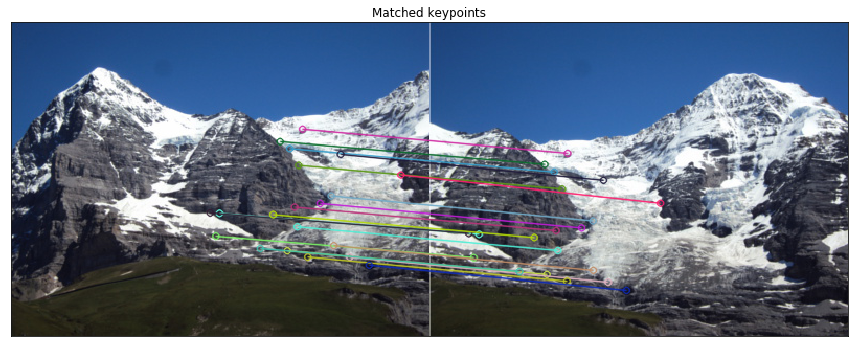

In [35]:
# create BFMatcher object
bf = cv2.BFMatcher()#cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 20 matches.
nb = 20
match_res = cv2.drawMatches(hill1,kp1,hill2,kp2, matches[:nb], hill1, flags=2)

plt.figure(figsize=(15,15))
plt.imshow(match_res)
plt.title("Matched keypoints"), plt.xticks([]), plt.yticks([])
plt.show()